In [30]:
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
# import pydda
import wradlib as wrl
import xarray as xr
import xradar as xd
import datatree
import urllib.request
url = "https://raw.githubusercontent.com/syedhamidali/test_scripts/master/map_features.py"
urllib.request.urlretrieve(url, "map_features.py")
import map_features as mf
url2 = "https://raw.githubusercontent.com/syedhamidali/test_scripts/master/nearest_nexrad.py"
urllib.request.urlretrieve(url2, "nearest_nexrad.py")
import nearest_nexrad as nrnx
import pyart
from pyart.retrieve import get_freq_band
import pandas as pd
import datetime as dt
import numpy as np
# import pathlib
# import scipy
# import wradlib as wrl
# import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter, FuncFormatter
from matplotlib import axes
import cartopy.crs as ccrs
import cartopy.feature as feat
import shapely.geometry as sgeom
from cartopy.geodesic import Geodesic
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import USCOUNTIES
import glob, os, sys, re
%matplotlib inline

In [31]:
def align_field(field):
    values, counts = np.unique(field['data'], return_counts=True)
    c_value = values[np.argmax(counts)]
    field['data'] = np.array([c_value])
    return field

def align_radar_coords(radar):
    radar.longitude = align_field(radar.longitude)
    radar.latitude = align_field(radar.latitude)
    radar.altitude = align_field(radar.altitude)
    radar.altitude_agl = align_field(radar.altitude_agl)
    return radar

In [42]:
def filter_radar(radar, vel_field="VEL_F", refl_field="DBZHCC_F", 
                 ncp_field="NCP", rhv_field="RHOHV", phi_field="PHIDP"):
    '''Remove noise based on velocity texture and mask all the fields'''
    # Drop some fields
    fields_to_drop = ["DBMHC", "DBMVC", "VS", "VS_F", "VL", "VL_F", "DBZHCC"]
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]
        
    texture = pyart.retrieve.calculate_velocity_texture(radar, 
                                                        vel_field=vel_field, 
                                                        wind_size=5, 
                                                        check_nyq_uniform=False)
    radar.add_field('VT',texture,replace_existing=True)
    # create gatefilter
    gf = pyart.filters.GateFilter(radar)
    BAND = get_freq_band(radar.instrument_parameters['frequency']['data'])
    if BAND is "X":
        vt = 4
    if BAND is "C":
        vt = 25
    gf.exclude_above('VT', vt)
    gf.exclude_invalid(refl_field)
    gf.exclude_outside(refl_field, -30, 100)
    gf.exclude_below("SNRHC", 0)
    gf_despeckeld = pyart.correct.despeckle_field(radar, refl_field, gatefilter=gf)
    corr_ZH = radar.fields[refl_field].copy()
    ZH_array = np.ma.masked_where(gf_despeckeld.gate_included == False, radar.fields[refl_field]['data'])
    corr_ZH['data'] = ZH_array
    radar.add_field('DBZH',corr_ZH,replace_existing=True)
    
    # get the mask
    mask = np.ma.getmask(radar.fields['DBZH']['data'])
    radar.scan_type = b'ppi'
    # iterate through remaining fields
    skip_fields = ["DBZHC", "VEL"]
    for field in radar.fields.keys():
        if any(field == skip_field for skip_field in skip_fields):
            continue
        # mask the field
        radar.fields[field]['data'] = np.ma.masked_where(mask, radar.fields[field]['data'])
    return radar

In [43]:
def dealiase(radar, vel_name = "VEL_F"):
    try: 
        gatefilter = pyart.correct.GateFilter(radar)
        corr_vel   = pyart.correct.dealias_region_based(
            radar, vel_field=vel_name, keep_original=False, gatefilter = gatefilter)
        radar.add_field(vel_name, corr_vel, replace_existing=True)
    except:
        None

In [44]:
def qc(file=None, savedir = "COW1/QC/"):
    radar = pyart.io.read(file)
    radar = align_radar_coords(radar)
    print("")
    print(f"Band: {get_freq_band(radar.instrument_parameters['frequency']['data'])}")
    print("")
    print(f"Range [km] {radar.range['data'].max()/1e3}")
    print("")
    print("Nearest NEXRAD site:")
    display(nrnx.nearest_sites(radar.latitude['data'], radar.longitude['data'], 3))
    print("")
    print(radar.fields.keys())
    print("Coords: ", radar.longitude['data'],
          radar.latitude['data'],
          radar.altitude['data'],)
    radar = filter_radar(radar)
    dealiase(radar)
#     pyart.io.write(os.path.join(basedir, savedir, file))
    return radar

In [45]:
def plot_radar(radar):
    # Let us view the vleocity with the filter applied.
    fig = plt.figure(figsize=[10, 8])
    display = pyart.graph.RadarMapDisplay(radar)
    ax = plt.subplot(221)
    display.plot_ppi("DBZHC", vmin=-10., vmax=70., cmap='pyart_HomeyerRainbow')
    ax = plt.subplot(222)
    display.plot_ppi("DBZH", vmin=-10., vmax=70., cmap='pyart_HomeyerRainbow', title='filtered')
    ax = plt.subplot(223)
    display.plot_ppi("VEL", sweep=0, cmap="pyart_NWSVel", vmin = -30, vmax = 30,)
    ax = plt.subplot(224)
    display.plot_ppi("VEL_F", sweep=0, cmap="pyart_NWSVel", vmin = -30, vmax = 30, title = "filtered")
    plt.show()

In [46]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1/"
cow = os.path.join(basedir, "COW1/cmerged/20220322/")

In [47]:
files = glob.glob(os.path.join(cow, "*"))
files.sort()
len(files)

181


Band: C

Range [km] 88.443421875

Nearest NEXRAD site:


,ID,lat,lon,elev,distance
63,KGWX,33.89667,-88.32889,476.0,1.151226
13,KBMX,33.17194,-86.76972,645.0,1.230432
31,KDGX,32.28000,-89.98444,-99999.0,2.106446



dict_keys(['NCP', 'TRIP_FLA', 'SNRHC', 'SNRVC', 'DBMHC', 'DBMVC', 'DBZHC', 'DBZHC_F', 'DBZVC', 'DBZVC_F', 'VEL', 'VEL_F', 'VS', 'VS_F', 'VL', 'VL_F', 'WIDTH', 'ZDRM', 'RHOHV', 'PHIDP', 'KDP', 'DBZHCC', 'DBZHCC_F', 'ZDRC'])
Coords:  [-87.9460144] [32.81097794] [57.99999833]


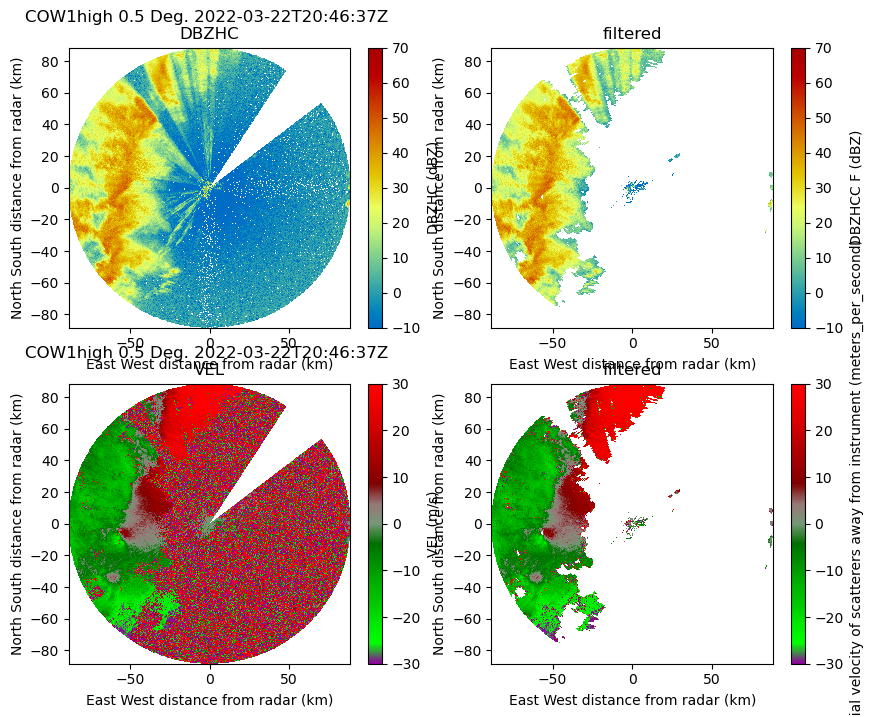

In [48]:
radar = qc(files[112])
cow_loc = (radar.longitude['data'], radar.latitude['data'])
plot_radar(radar)

Text(0, 0.5, 'Count')

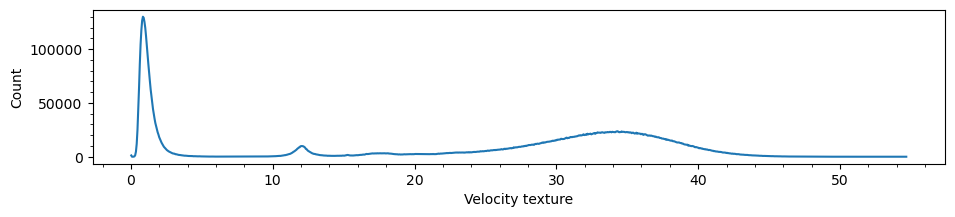

In [122]:
# Set the nyquist to what we see in the instrument parameter above.
# Calculate the velocity texture
vel_texture = pyart.retrieve.calculate_velocity_texture(
    radar, vel_field="VEL_F", wind_size=3)
radar.add_field("VT", vel_texture, replace_existing=True)

# Plot a histogram of velocity texture to get a better idea of what values correspond to
# hydrometeors and what values of texture correspond to artifacts.
# In the below example, a threshold of 3 would eliminate most of the peak corresponding to noise
# around 6 while preserving most of the values in the peak of ~0.5 corresponding to hydrometeors.
hist, bins = np.histogram(radar.fields["VT"]["data"], bins=1000)
bins = (bins[1:] + bins[:-1]) / 2.0
plt.figure(figsize = [11, 2])
plt.plot(bins, hist)
plt.minorticks_on()
plt.xlabel("Velocity texture")
plt.ylabel("Count")

In [123]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1/"
dow7 = os.path.join(basedir, "DOW7/cmerged/20220322/")

In [124]:
files = glob.glob(os.path.join(dow7, "*"))
files.sort()
len(files)

167


Band: X

Range [km] 74.960421875

Nearest NEXRAD site:


,ID,lat,lon,elev,distance
63,KGWX,33.89667,-88.32889,476.0,1.196174



dict_keys(['NCP', 'TRIP_FLA', 'SNRHC', 'SNRVC', 'DBMHC', 'DBMVC', 'DBZHC', 'DBZHC_F', 'DBZVC', 'DBZVC_F', 'VEL', 'VEL_F', 'VS', 'VS_F', 'VL', 'VL_F', 'WIDTH', 'ZDRM', 'RHOHV', 'PHIDP', 'KDP', 'DBZHCC', 'DBZHCC_F', 'ZDRC'])
Coords:  [-88.17179108] [32.71085739] [52.99999937]


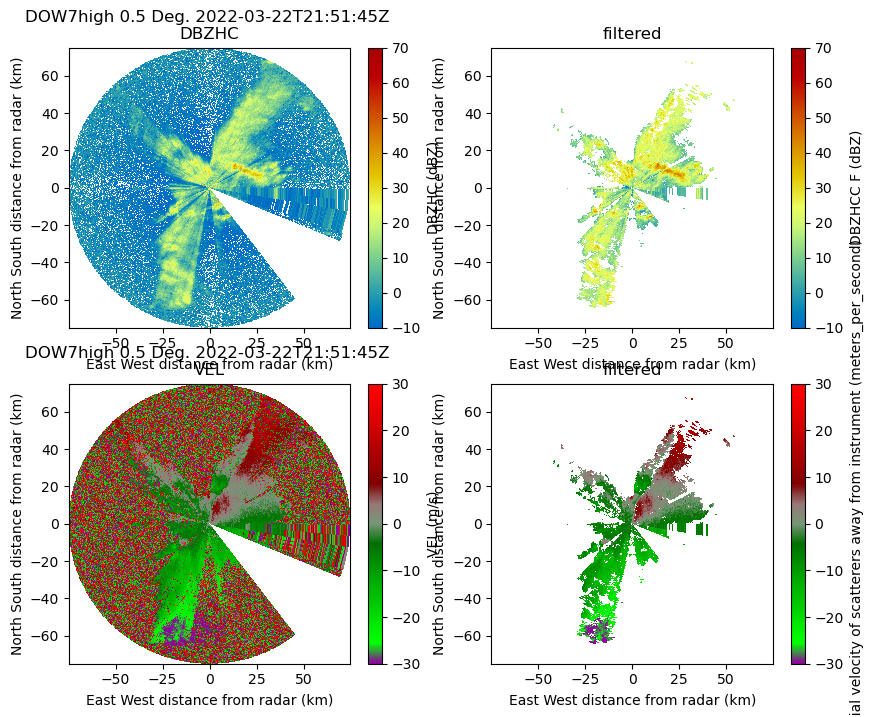

In [125]:
radar = qc(files[113], savedir=None)
dow7_loc = (radar.longitude['data'], radar.latitude['data'])
plot_radar(radar)

Text(0, 0.5, 'Count')

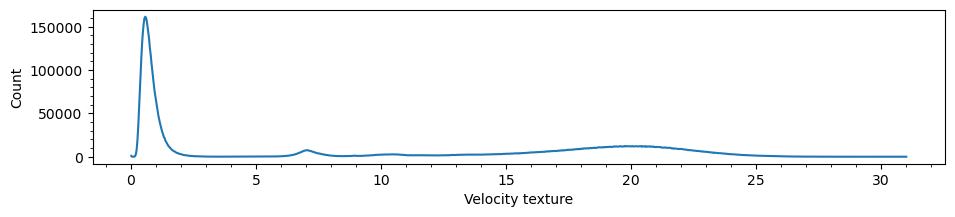

In [70]:
# Set the nyquist to what we see in the instrument parameter above.
# Calculate the velocity texture
vel_texture = pyart.retrieve.calculate_velocity_texture(
    radar, vel_field="VEL_F", wind_size=3)
radar.add_field("VT", vel_texture, replace_existing=True)

hist, bins = np.histogram(radar.fields["VT"]["data"], bins=1000)
bins = (bins[1:] + bins[:-1]) / 2.0
plt.figure(figsize = [11, 2])
plt.plot(bins, hist)
plt.minorticks_on()
plt.xlabel("Velocity texture")
plt.ylabel("Count")

In [71]:
dow7_loc

(array([-88.17179108]), array([32.71085739]))

In [72]:
cow_loc

(array([-87.9460144]), array([32.81097794]))

In [73]:
nearest_site(dow7_loc[1], dow7_loc[0], sites)

,ID,lat,lon,elev,distance
63,KGWX,33.89667,-88.32889,476.0,1.196174


In [74]:
nearest_site(cow_loc[1], cow_loc[0], sites)

,ID,lat,lon,elev,distance
63,KGWX,33.89667,-88.32889,476.0,1.151226


In [75]:
kgwx = (np.array([-88.32889]), np.array([33.89667]))

In [76]:
dow7_loc, cow_loc, kgwx

((array([-88.17179108]), array([32.71085739])),
 (array([-87.9460144]), array([32.81097794])),
 (array([-88.32889]), array([33.89667])))

In [126]:
def add_patch(ax, xy, radius = None, fc='none', ):
    if radius>100:
        zorder = -1
    else:
        zorder = 0
    ax.add_patch(mpatches.Circle(xy=xy, radius=(radius*(np.pi/180)),
                                 facecolor=fc,
                                 ec = "k",
                                 lw = 1,
                                 alpha=0.2,
                                 zorder = zorder, 
                                 transform=ccrs.LambertConformal()))

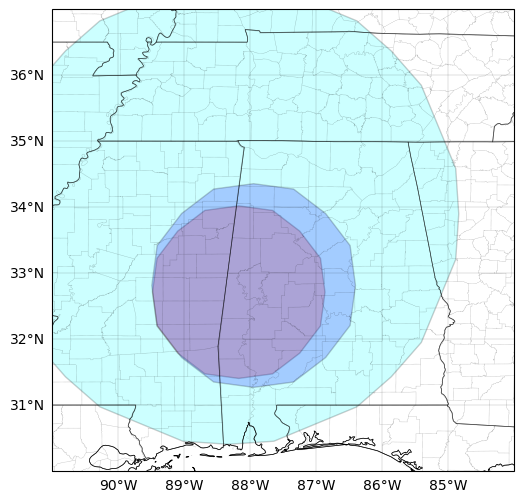

In [559]:
fig = plt.figure(figsize=[6, 6])
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([-91, -84, 30, 37], ccrs.Geodetic())
add_patch(ax, xy = dow7_loc, radius=74.9, fc='r') #dow
add_patch(ax, xy = cow_loc, radius=88.4, fc='b') #cow
add_patch(ax, xy = kgwx, radius = 200, fc = "cyan")
mf.map_features(ax, b=1, l=1, coastline=True, states=True, counties=True)
plt.show()

In [778]:
def draw_ring(ax, lon, lat, radius, ec="k", fc='none', lw=1, ls="-", alpha=1):  
    gd = Geodesic()
    cp = gd.circle(lon=lon, lat=lat, radius=radius) # radius in meter
    geoms = sgeom.Polygon(cp)
    ax.add_geometries([geoms], crs=ccrs.PlateCarree(), ec=ec, fc=fc, lw=lw, ls=ls, alpha=alpha)

In [779]:
dow7_loc, cow_loc, kgwx

((array([-88.17179108]), array([32.71085739])),
 (array([-87.9460144]), array([32.81097794])),
 (array([-88.32889]), array([33.89667])))

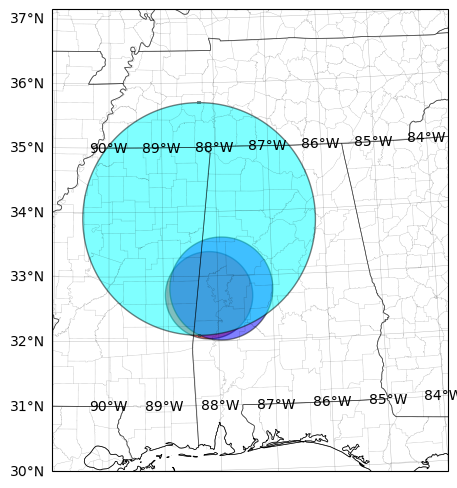

In [742]:
fig = plt.figure(figsize=[6, 6])
proj= ccrs.LambertConformal(central_longitude=-90, central_latitude=32)
ax = plt.axes(projection = proj)
ax.set_extent([-91, -84, 30, 37], ccrs.Geodetic())
draw_ring(ax=ax, lon=-88.17179108, lat=32.71085739, radius=[74.9*1000], fc='r', alpha=0.5) #dow
draw_ring(ax=ax, lon=-87.9460144, lat=32.81097794, radius=[88.4*1000], fc='b', alpha=0.5) #cow
draw_ring(ax=ax, lon=-88.32889, lat=33.89667, radius = [200*1000], fc = "cyan", alpha=0.5)
mf.map_features(ax, b=1, l=1, coastline=True, states=True, counties=True)
plt.show()

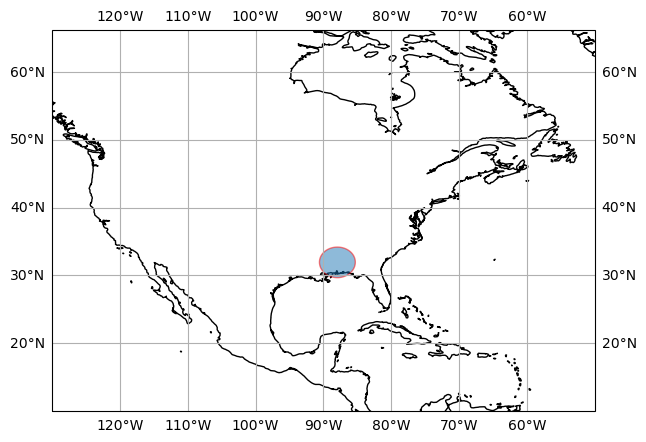

In [3]:
def draw_ring(ax, lons, lats, radius, ec="k", fc='none', lw=1, ls="-", alpha=1):  
    gd = Geodesic()
    cp = gd.circle(lon=lon, lat=lat, radius=radius) # radius in meter
    geoms = []
    for lon, lat in zip(lons, lats):
        cp = gd.circle(lon=lon, lat=lat, radius=radius)
        geoms.append(sgeom.Polygon(cp))
    ax.add_geometries(geoms, crs=ccrs.PlateCarree(), ec=ec, fc=fc, lw=lw, ls=ls, alpha=alpha)

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import numpy as np
from cartopy.geodesic import Geodesic
gd = Geodesic()
crs1 = ccrs.PlateCarree()
lats=[32]
lons=[-88]
proj= ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=proj)
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True)
geoms = []
for lon, lat in zip(lons, lats):
    cp = gd.circle(lon=lon, lat=lat, radius=250000.) # radius in meter
    geoms.append(sgeom.Polygon(cp))
ax.add_geometries(geoms, crs=crs1, edgecolor='r', alpha=0.5)
ax.set_extent([-130., -50., 10., 60.])
plt.show()

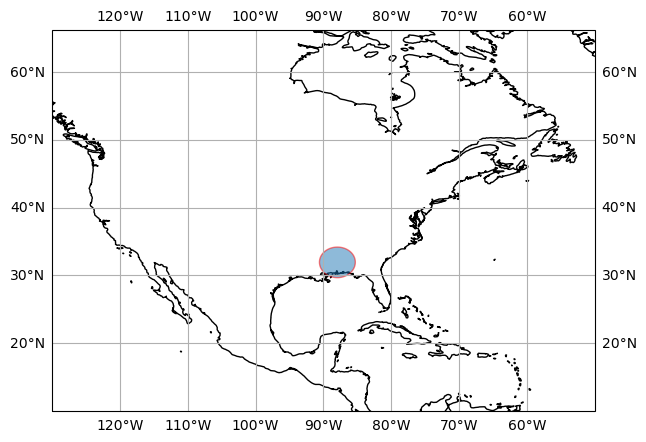

In [736]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import numpy as np
from cartopy.geodesic import Geodesic
gd = Geodesic()
crs1 = ccrs.PlateCarree()
lats=[32]
lons=[-88]
proj= ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=proj)
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True)
geoms = []
for lon, lat in zip(lons, lats):
    cp = gd.circle(lon=lon, lat=lat, radius=250000.) # radius in meter
    geoms.append(sgeom.Polygon(cp))
ax.add_geometries(geoms, crs=crs1, edgecolor='r', alpha=0.5)
ax.set_extent([-130., -50., 10., 60.])
plt.show()

In [235]:
radar = pyart.io.read_cfradial(files[111])

In [236]:
display = pyart.graph.RadarMapDisplay(radar)

In [456]:
proj = ccrs.PlateCarree()

In [507]:
lat, lon, _ = radar.get_gate_lat_lon_alt(0)

In [508]:
lat.min(), lat.max(), lon.min(), lon.max()

(32.015717, 33.606236, -88.89224, -86.99978)

In [689]:
fig = plt.figure(figsize = [7, 5], tight_layout=True)
ax = plt.axes(projection=ccrs.AzimuthalEquidistant(radar.longitude['data'].max(),
                                                            radar.latitude['data'].max()), globe = ccrs.CRS())
ax.set_extent([-180, 180, -90, 90], crs = ccrs.Geodetic())
# display.plot_ppi_map("DBZHCC_F",
#                      0, vmin = -10,
#                      vmax = 70, 
#                      cmap = "pyart_NWSRef",
#                      ax=ax,
#                      fig=fig,
#                      projection = ccrs.AzimuthalEquidistant(radar.longitude['data'].max(),
#                                                             radar.latitude['data'].max()),
#                     )

ax.add_patch(mpatches.Circle(xy=[radar.longitude['data'].max(), radar.latitude['data'].max()],
                             radius = km_to_deg(88), 
                             facecolor='none',
                             ec = "k",
                             lw = 1,
                             alpha=1,
                             zorder = 3, transform = ccrs.LambertAzimuthalEqualArea(radar.longitude['data'].max(),
                                                            radar.latitude['data'].max()))
            )
ax.gridlines(draw_labels=True)

TypeError: CRS.__init__() missing 1 required positional argument: 'proj4_params'

<Figure size 700x500 with 0 Axes>

In [404]:
radar.longitude['data'].max(), radar.latitude['data'].max()

(-87.94601440429688, 32.810977935791016)

In [417]:
np.radians(100)

1.7453292519943295

In [422]:
np.degrees(1)

57.29577951308232

In [421]:
np.rad2deg(1)

57.29577951308232

In [424]:
np.radians(1)

0.017453292519943295

In [426]:
(111)

111

In [519]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import urllib.request
import io

In [524]:
def load_data_from_web(url):
    '''url(str): Data file address/link'''
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as resp:
        ds = xr.open_dataset(io.BytesIO(resp.read()))
    return ds

In [525]:
%%time
base_url = "https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis/Dailies/pressure/{variable}.{year}.nc"
years = [2020,]
variables = ["air",]


ds = []
for variable in variables:
    for year in years:
        url = base_url.replace("{variable}", variable).replace("{year}", str(year))
        ds.append(load_data_from_web(url))
ds = xr.merge(ds)

CPU times: user 93.5 ms, sys: 106 ms, total: 200 ms
Wall time: 1.23 s


In [549]:
url1 = "https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis/Dailies/pressure/air.2021.nc"

In [554]:
del ds

In [555]:
ds = []
for url in [url1]:
    ds.append(load_data_from_web(url))
ds = xr.merge(ds)

In [548]:
def align_coords(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(["lat", "lon"])
    return ds

In [572]:
ds = align_coords(ds)

In [640]:
def km_to_deg(km):
    """Convert kilometers to degrees."""
    Earth_radius = 6371.0 # Earth's average radius in km
    return km / Earth_radius * (360 / (2 * np.pi))

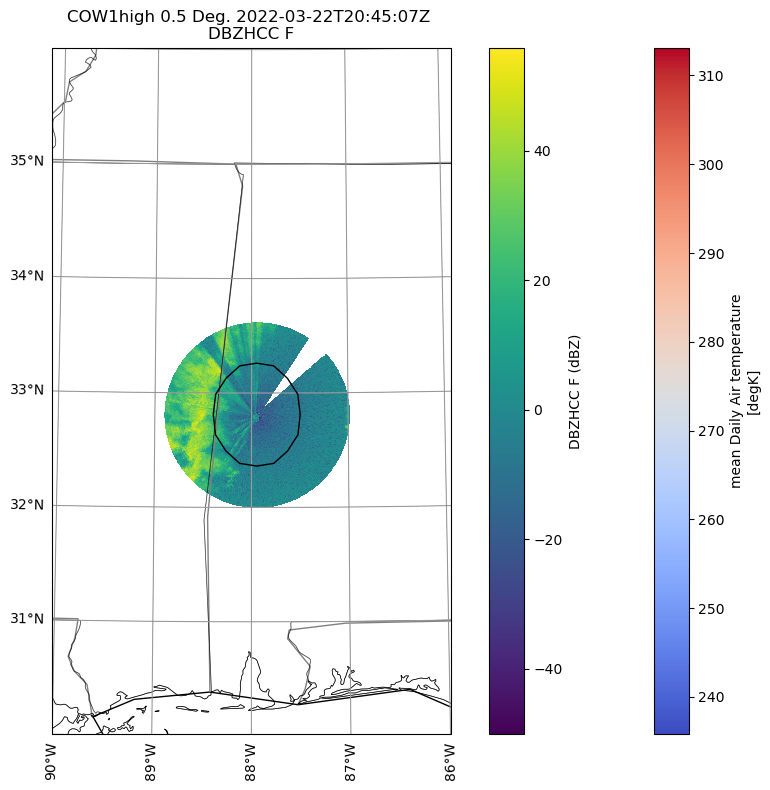

In [699]:
plt.figure(figsize=[10, 8], tight_layout = True)
ax = plt.axes(projection = ccrs.AzimuthalEquidistant(radar.longitude['data'].max(),
                                                     radar.latitude['data'].max()))
ax.set_extent([-90, -86, 30, 36])
ds.air[0, 0].plot(ax=ax, cmap = "coolwarm")
ax.add_patch(mpatches.Circle(xy=[radar.longitude['data'].max(), radar.latitude['data'].max()],
                             radius = km_to_deg(50), 
                             facecolor='none',
                             ec = "k",
                             lw = 1,
                             alpha=1,
                             zorder = 3, 
                             transform = ccrs.PlateCarree())
            )

display.plot_ppi_map("DBZHCC_F", 0, ax=ax, fig=fig,
                     projection = ccrs.LambertConformal(radar.longitude['data'].max(),
                                                        radar.latitude['data'].max())
                    )
mf.map_features(ax=ax, coastline=1, borders=1, b=1, l=1)

In [744]:
import nearest_nexrad as nrnx

In [770]:
proj = ccrs.LambertConformal(radar.longitude['data'].max(), radar.latitude['data'].max())

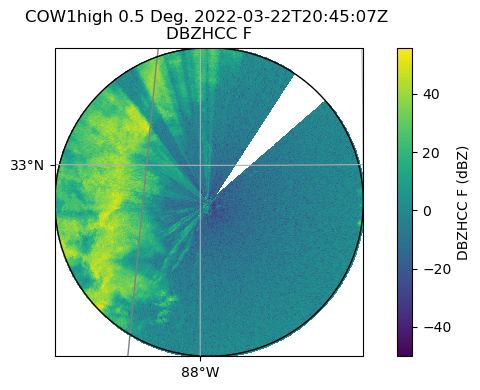

In [786]:
fig = plt.figure(figsize=[7,4], tight_layout = True)
ax = plt.axes(projection = proj)

display.plot_ppi_map("DBZHCC_F", 0, ax=ax, fig=fig,
                     projection = proj)
draw_ring(ax=ax,
          lon=radar.longitude['data'].max(),
          lat=radar.latitude['data'].max(),
          radius=radar.range['data'].max(),
         )
# mf.map_features(ax=ax, coastline=1, borders=1, b=1, l=1)

In [764]:
proj = ccrs.LambertConformal(radar.longitude['data'].max(), radar.latitude['data'].max(),
                            false_easting=0.0, 
                            false_northing=0.0, 
                            standard_parallels=(30, 50), 
                            globe=None, 
                            cutoff=-30
                            )

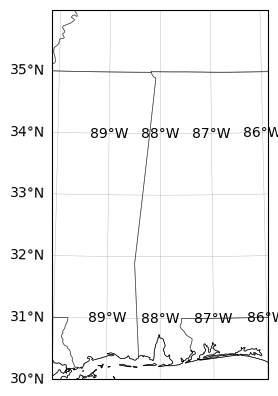

In [767]:
fig = plt.figure()
ax = plt.axes(projection=proj)
ax.set_extent([-90, -86, 30, 36])
mf.map_features(ax=ax, coastline=True, b=1, l=1, borders=True, grids=True)

In [777]:
def map_features(ax, b=False, l=False, t=False, r=False, coastline=False, 
                     borders=False, ocean=False, states=True, counties=False, 
                     land=False, grids=False):
    '''Add cartopy features to the axis'''
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='black', 
                      alpha=0.3, linestyle='-', draw_labels=True)
    gl.xlabels_top = t
    gl.xlabels_bottom = b
    gl.ylabels_left = l
    gl.ylabels_right = r
    if grids:
        gl.xlines = True
        gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if borders:
        ax.add_feature(feat.BORDERS, lw = 0.5)
    if land:
        ax.add_feature(feat.LAND, lw = 0.3, fc = [0.9,0.9,0.9])
    if coastline:
        ax.add_feature(feat.COASTLINE, lw = 0.5)
    if ocean:
        ax.add_feature(feat.OCEAN, alpha = 0.5)
    if states:
        ax.add_feature(feat.STATES.with_scale("10m"), alpha = 0.5, lw = 0.5)
    if counties:
        ax.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.3, linestyle=':', lw = 0.3)

'''
import urllib.request
url = "https://raw.githubusercontent.com/syedhamidali/test_scripts/master/map_features.py"
urllib.request.urlretrieve(url, "map_features.py")
import map_features as mf
'''


import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import USCOUNTIES

def map_features(ax, b=False, l=False, t=False, r=False, coastline=False, 
                     borders=False, ocean=False, states=True, counties=False, 
                     land=False, grids=False):
    '''Add cartopy features to the axis'''
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='black', 
                      alpha=0.3, linestyle='-', draw_labels=True)
    gl.xlabels_top = t
    gl.xlabels_bottom = b
    gl.ylabels_left = l
    gl.ylabels_right = r
    if grids:
        gl.xlines = True
        gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    